# Computer Vision and Image Processing M
## Augmented reality project
### Quaranta Lorenzo - s0001054106

***Input Data:***
The augmented reality system should process the following input data:
- Input video sequence to be augmented: Multiple View.avi
- Reference frame (first frame of the input sequence): ReferenceFrame.png
- Binary mask that identifies the pixels belonging to the book in the reference frame:
ObjectMask.png
- Image containing the augmented reality layer, made out of the CVLab logo and a different
list of authors (i.e. Richard Hartley and Andrew Zissermann and Pietro Azzari) together
with the associated binary mask: AugmentedLayer.png, AugmentedLayerMask.png

***Goal:***
Students should develop a software system aimed at creating an Augmented Reality (AR) video which superimpose an augmented reality layer onto the book cover 
as realistically as possible

# 0 - Imports and utilities

### Imports

libraries import and path variables initialization

In [12]:
import os
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

# Constants
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1
FLANN_INDEX_LSH = 6
SAVED_VIDEO_FPS = 15
F2R_FC = 5 # frequency for mixed F2R and F2F approach
RANSAC_REPROJ_THRESH = 5.0 # ransac reprojection threshold
LOWE_RATIO = 0.7 # lowe ratio for flann matcher

# Paths for input/output
data_folder = "./Data/"
output_folder = "./Outputs/"
output_F2R_folder = output_folder + "./F2R/" 
output_F2F_folder = output_folder + "./F2F/" 
output_Variants_folder = output_folder + "./Variants/" 
output_comparisons_folder = output_folder + "./Comparisons/"

reference_frame_path = data_folder + "ReferenceFrame.png"
augmented_layer_path = data_folder + "AugmentedLayer.PNG"

object_mask_path = data_folder + "ObjectMask.PNG"
augmented_layer_mask_path = data_folder + "AugmentedLayerMask.PNG"

video_path = data_folder + "Multiple View.avi"

output_video_name = "Augmented Multiple View.avi"
output_video_F2R_path = output_F2R_folder + output_video_name
output_video_F2F_path = output_F2F_folder + output_video_name

output_video_F2R_F2F_path   = output_comparisons_folder + "Augmented Multiple View - F2R vs F2F.avi"
output_video_F2R_Mixed_path   = output_comparisons_folder + "Augmented Multiple View - F2R vs Mixed.avi"

# SIFT detector
# sift = cv2.xfeatures2d.SIFT_create() # OpenCV 3.4.2
sift = cv2.SIFT.create() # OpenCV 4.5.1

### Utility functions

In [2]:
# show an image with/without a description
def show_image(image, desc = None, show_axes = True):
    if desc is not None:
        print(desc)
    
    plt.axis("on" if show_axes else "off")     
    plt.imshow(image)
    plt.show()

# detection of keypoints and descriptors in the image
def run_SIFT(image_grayscale, mask = None):
    global sift
    
    # Detecting keypoints in the image
    if mask is not None:
        # The mask can be used to look for keypoints inside a ROI 
        # (ransac make this step almost irrelevant though)
        keypoints = sift.detect(image_grayscale, mask) 
    else:
        keypoints = sift.detect(image_grayscale)
        
    # Computing the descriptors for each keypoint
    return sift.compute(image_grayscale, keypoints) # keypoints, descriptors

orb = cv2.ORB_create()
def run_ORB(image):
    global orb

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)

    return keypoints, descriptors

# AKAZE feature detector
akaze = cv2.AKAZE_create()

def run_AKAZE(image):
    kp, des = akaze.detectAndCompute(image, None)
    return kp, des

def play_video(video_path):
    video = cv2.VideoCapture(video_path)
    frame_rate = video.get(cv2.CAP_PROP_FPS)
    while True:
        ret, frame = video.read()
        if not ret:
            break
        cv2.imshow('Video', frame)

        delay = int(1000 / frame_rate)

        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    video.release()
    cv2.destroyAllWindows()

def get_total_frames(video_path):
    """
    Get the total number of frames in a video.

    Parameters:
    - video_path: Path to the video file.

    Returns:
    - total_frames: Total number of frames in the video.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open the video file.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cap.release()

    return total_frames

def save_video(frames, video_path, frame_rate=30):
    """
    Save a video from a sequence of frames.

    Parameters:
    - frames: List of frames (NumPy arrays) to be saved as a video.
    - video_path: Path to the video file to be saved.
    - frame_rate: Frames per second (default is 30).
    """
    if not frames:
        print("No frames provided.")
        return
    
    # Check if the directory exists, if not, create it
    directory = os.path.dirname(video_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    height, width, _ = frames[0].shape
    video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), frame_rate, (width, height))

    for frame in frames:
        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    video_writer.release()
    
def get_video_side_by_side(video_path1, video_path2, video_size=(480, 360)):
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)
    result = []
    try:
        while cap1.isOpened() and cap2.isOpened():
            ret1, frame1 = cap1.read()
            ret2, frame2 = cap2.read()

            if not ret1 or not ret2:
                break

            # Resize frames
            frame1 = cv2.resize(frame1, video_size)
            frame2 = cv2.resize(frame2, video_size)

            # Concatenate frames horizontally
            concat_frame = np.concatenate((frame1, frame2), axis=1)

            # Convert color from BGR to RGB
            concat_frame = cv2.cvtColor(concat_frame, cv2.COLOR_BGR2RGB)

            result.append(concat_frame)
    finally:
        cap1.release()
        cap2.release()
    return result
    
def display_videos_side_by_side(video_path1, video_path2, output_path, video_size=(480, 360), display = True,  save = False):
    comparison_video = get_video_side_by_side(video_path1, video_path2, video_size)
    if save:
        save_video(comparison_video, output_path, SAVED_VIDEO_FPS)
    
    if display:
        display_video_in_jupyter(comparison_video)

def display_video_in_jupyter(frames):
    """
    Display a video from a sequence of frames in Jupyter notebook.

    Parameters:
    - frames: List of frames (NumPy arrays) to be displayed as a video.
    """
    for frame in frames:
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
        clear_output(wait=True)

# 1 - Images elaboration

Augmented layer initialization and elaboration.Images are cropped to be the same size

In [3]:
# Load the first frame of the video (reference frame)
reference_frame_bgr = cv2.imread(reference_frame_path)
reference_frame_rgb = cv2.cvtColor(reference_frame_bgr, cv2.COLOR_BGR2RGB)
reference_frame_grayscale = cv2.cvtColor(reference_frame_bgr, cv2.COLOR_BGR2GRAY)
reference_frame_rows, reference_frame_cols = reference_frame_rgb.shape[0], reference_frame_rgb.shape[1] #480x640

# Load the augmented reality layer
augmented_layer_bgr = cv2.imread(augmented_layer_path)
augmented_layer_rgb = cv2.cvtColor(augmented_layer_bgr, cv2.COLOR_BGR2RGB)
augmented_layer_rgb = augmented_layer_rgb[:reference_frame_rows, :reference_frame_cols] #crop from 480x1525 to 480x640

# Load the agumented reality layer binary mask
augmented_layer_mask = cv2.imread(augmented_layer_mask_path)
augmented_layer_mask = augmented_layer_mask[:reference_frame_rows, :reference_frame_cols] #crop from 480x1525 to 480x640

Improvement of AR layer to avoid colour artefacts. We only use the third author text instead of a colored rectangle containing all authors

In [4]:
# Extraction of third author from binary mask
third_author_mask = np.zeros((reference_frame_rows, reference_frame_cols, 3), dtype = np.uint8)
third_author_color = [201, 255, 255] #rgb color of the third author in the mask
third_author_pixels = np.where((augmented_layer_rgb == third_author_color).all(axis = 2))
third_author_mask[third_author_pixels] = 255 #make them white

# Dilation of the third author mask to avoid artefacts during warping
dilation_kernel = np.ones((3, 3), np.uint8)
third_author_mask_dilated = cv2.dilate(third_author_mask, dilation_kernel, 1) 

# # Update the augmented reality binary mask and
augmented_layer_mask[300:,:] = third_author_mask_dilated[300:, :] # first 300 rows includes logo, so we don't want to update them
augmented_layer_rgb[np.where(augmented_layer_mask == 0)] = 0

Reference Frame


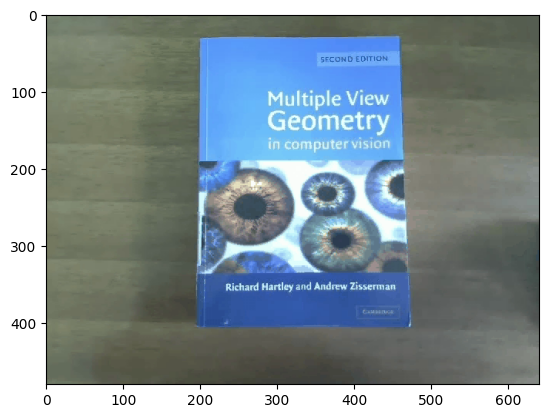

Updated Augmented Reality Layer


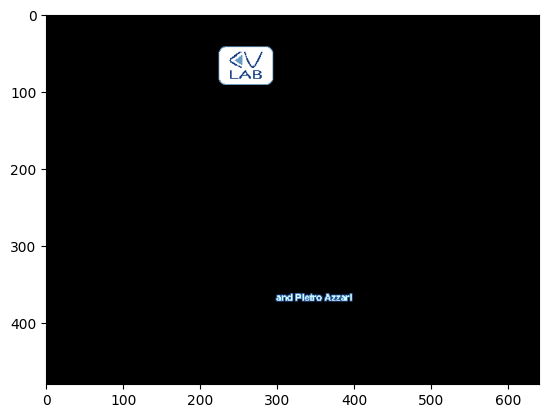

Updated Augmented Layer Binary Mask


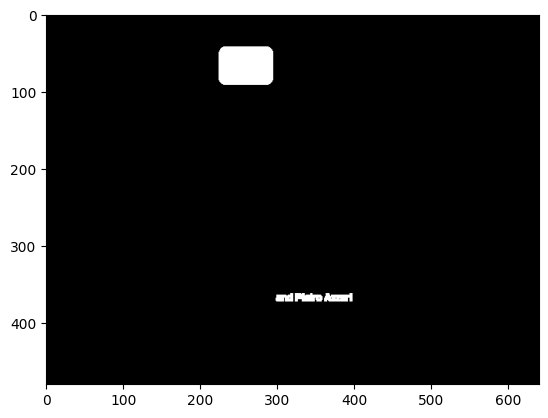

In [5]:
# Show the rgb version of the reference frame
show_image(reference_frame_rgb, "Reference Frame")

# Show the rgb version of the augmented reality layer
show_image(augmented_layer_rgb, "Updated Augmented Reality Layer")

# Show the provided augmented layer binary mask
show_image(augmented_layer_mask, "Updated Augmented Layer Binary Mask")

# 2 - Solutions

2 main solutions are proposed plus a few variants in the attempt to improve the result.

## 2.a - Frame to Reference approach (F2R)

First solution - An homography is found between the first reference frame and each frame. The augmented layer is then warped to match the current position in the video.

In [6]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# reference keypoints/descriptors
kp_query, des_query = run_SIFT(reference_frame_grayscale)

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2R(frame):
    global frame_num, total_frames_num

    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Run SIFT on the current frame
    kp_train, des_train = run_SIFT(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        return frame
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]
    
    return final_frame


# processing video
video = cv2.VideoCapture(video_path)
F2R_frames_buffer = []

start = time.time()
# Play the video
try:
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()
        
        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2R(current_frame)
            if augmented_frame is not None:
                F2R_frames_buffer.append(augmented_frame)
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  33.05347681045532


Save the augmented video

In [7]:
filepath = os.path.abspath(output_video_F2R_path)

save_video(F2R_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

## 2.b - Frame to Frame (F2F)

Second solution - the homography is calculated between each consecutive frame and accumulated with a dot product.

In [8]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# first homography is identity matrix
homography_matrix = np.identity(3, dtype = np.float32) #3x3 identity matrix

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2F(current_frame, previous_frame):
    global frame_num, total_frames_num
    global homography_matrix
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the previous_frame for SIFT    
    previous_frame_grayscale = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Run SIFT on the previous frame
    kp_query, des_query = run_SIFT(previous_frame_grayscale)
    # Run SIFT on the current frame
    kp_train, des_train = run_SIFT(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        print ("Not enough matches are found between frame %d and %d" % (frame_num -1 ,frame_num))
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # update the homography matrix
    homography_matrix = np.dot(homography_matrix, M)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]

    return final_frame

# processing video
video = cv2.VideoCapture(video_path)
F2F_frames_buffer = []
# Play the video

start = time.time()
try:
    previous_frame = None
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()

        if previous_frame is None:
            previous_frame = current_frame

        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2F(current_frame, previous_frame)
            if augmented_frame is not None:
                F2F_frames_buffer.append(augmented_frame)
            previous_frame = current_frame
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  56.58472561836243


In [9]:
filepath = os.path.abspath(output_video_F2F_path)
save_video(F2F_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

## Variants

### alt 1 - mix F2R and F2F

Since the AR layer with F2R is shaky and with F2F drifts away, a tentative to solve both problem is to use both methods, using F2R only once every a chosen number of frames, so that the shakiness should be less present and the drifting is corrected by the F2R approach.

In [10]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# reference keypoints/descriptors
kp_ref, des_ref = run_SIFT(reference_frame_grayscale)

# first homography is identity matrix
homography_matrix = np.identity(3, dtype = np.float32) #3x3 identity matrix

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2F(current_frame, previous_frame):
    global frame_num, total_frames_num
    global homography_matrix
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the previous_frame for SIFT    
    previous_frame_grayscale = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    if (frame_num % F2R_FC) == 0:
        kp_query, des_query = kp_ref, des_ref
    else:
        kp_query, des_query = run_SIFT(previous_frame_grayscale)

    # Run SIFT on the current frame
    kp_train, des_train = run_SIFT(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        print ("Not enough matches are found between frame %d and %d" % (frame_num -1 ,frame_num))
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # update the homography matrix
    if (frame_num % F2R_FC) == 0:
        homography_matrix = np.mean([homography_matrix, M], axis = 0)
    else:
        homography_matrix = np.dot(homography_matrix, M)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]

    return final_frame

# processing video
video = cv2.VideoCapture(video_path)
F2F_frames_buffer = []
# Play the video

start = time.time()
try:
    previous_frame = None
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()

        if previous_frame is None:
            previous_frame = current_frame

        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2F(current_frame, previous_frame)
            if augmented_frame is not None:
                F2F_frames_buffer.append(augmented_frame)
            previous_frame = current_frame
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  51.79834604263306


In [13]:
filepath = os.path.abspath(output_Variants_folder + "Augmented Multiple View - Mixed.avi")

save_video(F2F_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

with AKAZE

In [14]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# reference keypoints/descriptors
kp_ref, des_ref = run_AKAZE(reference_frame_grayscale)

# first homography is identity matrix
homography_matrix = np.identity(3, dtype = np.float32) #3x3 identity matrix

# Initializing the matching algorithm
index_params = dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 2)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2F(current_frame, previous_frame):
    global frame_num, total_frames_num
    global homography_matrix
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the previous_frame for SIFT    
    previous_frame_grayscale = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    if (frame_num % 5) == 0:
        kp_query, des_query = kp_ref, des_ref
    else:
        kp_query, des_query = run_AKAZE(previous_frame_grayscale)

    # Run SIFT on the current frame
    kp_train, des_train = run_AKAZE(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        print ("Not enough matches are found between frame %d and %d" % (frame_num -1 ,frame_num))
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # update the homography matrix
    if (frame_num % 5) == 0:
        homography_matrix = np.mean([homography_matrix, M], axis = 0)
    else:
        homography_matrix = np.dot(homography_matrix, M)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]

    return final_frame

# processing video
video = cv2.VideoCapture(video_path)
F2F_frames_buffer = []
# Play the video

start = time.time()
try:
    previous_frame = None
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()

        if previous_frame is None:
            previous_frame = current_frame

        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2F(current_frame, previous_frame)
            if augmented_frame is not None:
                F2F_frames_buffer.append(augmented_frame)
            previous_frame = current_frame
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  24.94876980781555


In [15]:
filepath = os.path.abspath(output_Variants_folder + "Augmented Multiple View - Mixed AKAZE.avi")

save_video(F2F_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

### alt 2 - ORB / AKAZE instead of SIFT

Here is a tentative of using different feature detectors from SIFT: ORB and AKAZE. In this case different index parameters for FlannBasedMatcher are needed.

ORB

In [16]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# Run ORB on the previous frame
kp_query, des_query = run_ORB(reference_frame_grayscale)

# Initializing the matching algorithm
index_params = dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 2)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2R(frame):
    global frame_num, total_frames_num

    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Run ORB on the current frame
    kp_train, des_train = run_ORB(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if ORB found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        print ("Not enough matches are found between frame %d and %d" % (frame_num -1 ,frame_num))
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]
    
    return final_frame


# processing video
video = cv2.VideoCapture(video_path)
F2R_frames_buffer = []

start = time.time()
# Play the video
try:
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()
        
        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2R(current_frame)
            if augmented_frame is not None:
                F2R_frames_buffer.append(augmented_frame)
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  6.1556456089019775


In [17]:
filepath = os.path.abspath(output_Variants_folder + "Augmented Multiple View - ORB.avi")

save_video(F2R_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

Despite being way faster than SIFT, the result with ORB looks worse than any of the approaches already tried.

AKAZE

In [18]:
# Video playback variables
frame_num = 0 
total_frames_num = get_total_frames(video_path)

# Run AKAZE on the previous frame
kp_query, des_query = run_AKAZE(reference_frame_grayscale)

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 2)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_frame_F2R(frame):
    global frame_num, total_frames_num

    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {total_frames_num}")

    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Run AKAZE on the current frame
    kp_train, des_train = run_AKAZE(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            good.append(m)

    # Check if AKAZE found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        print ("Not enough matches are found between frame %d and %d" % (frame_num -1 ,frame_num))
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, RANSAC_REPROJ_THRESH)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        augmented_layer_rgb,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        augmented_layer_mask,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]
    
    return final_frame


# processing video
video = cv2.VideoCapture(video_path)
F2R_frames_buffer = []

start = time.time()
# Play the video
try:
    while(video.isOpened()):
        frame_read_correctly, current_frame = video.read()
        
        if not frame_read_correctly:
            break
        
        if current_frame is not None:
            augmented_frame = process_frame_F2R(current_frame)
            if augmented_frame is not None:
                F2R_frames_buffer.append(augmented_frame)
            
    video.release()
except KeyboardInterrupt:
    # If the stop button of jupyter notebook is pressed, release the video resources
    video.release()
    print("Released Video Resource")
print("Elapsed time: ", time.time() - start)

Frames processed: 420 / 420
Elapsed time:  17.03340482711792


In [19]:
filepath = os.path.abspath(output_Variants_folder + "Augmented Multiple View - AKAZE.avi")

save_video(F2R_frames_buffer, filepath, SAVED_VIDEO_FPS)
#play_video(filepath)

This approach looks the best so far, being faster than SIFT and also apparently more stable.

# Comparisons

F2R vs F2F

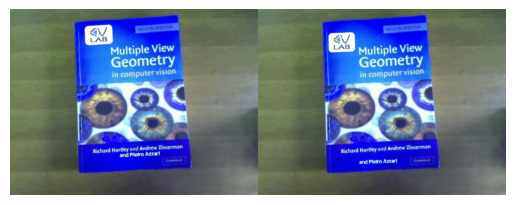

In [20]:
display_videos_side_by_side(output_video_F2R_path , output_video_F2F_path, output_video_F2R_F2F_path, save=True)

Different RANSAC Threshold values

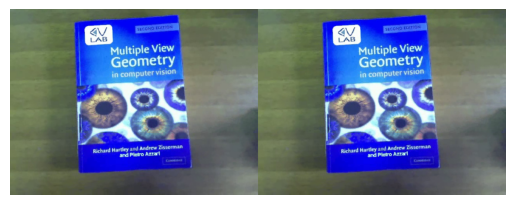

In [21]:
display_videos_side_by_side(output_video_F2R_path , output_Variants_folder + "Augmented Multiple View_ransac3.avi", output_comparisons_folder + " F2R base vs ransac3.avi", save=True)

SIFT vs AKAZE

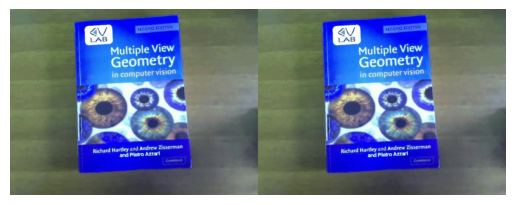

In [22]:
display_videos_side_by_side(output_video_F2R_path , output_Variants_folder + "Augmented Multiple View - AKAZE.avi", output_comparisons_folder + " F2R SIFT vs AKAZE.avi", save=True)

F2R vs Mixed

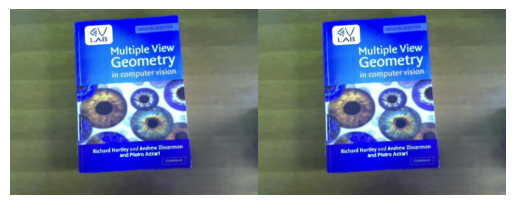

In [23]:
display_videos_side_by_side(output_video_F2R_path , output_Variants_folder + "Augmented Multiple View - Mixed.avi", output_comparisons_folder + " F2R SIFT vs mixed.avi", save=True)

AKAZE F2R vs Mixed

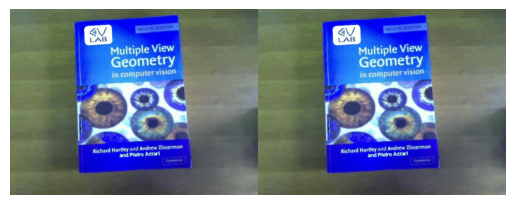

In [25]:
display_videos_side_by_side(output_Variants_folder + "Augmented Multiple View - Mixed AKAZE.avi" , output_Variants_folder + "Augmented Multiple View - AKAZE.avi", output_comparisons_folder + " AKAZE mixed vs AKAZE.avi", save=True)